In [168]:
import sys
if True:  # On colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/omega/"
    sys.path.append(root)
else:  # Local
    root = './'

Mounted at /content/drive


In [104]:
!pip3 install flax
#!pip3 install git+https://github.com/afqueiruga/simdatadb.git
#!pip3 install pymysql

In [1]:
from itertools import cycle, islice
from typing import Any, Callable, Iterable, NamedTuple, Tuple

import flax
import jax
import jax.numpy as jnp
from matplotlib import pylab as plt
import numpy as onp
#from SimDataDB import SimDataDB
import sklearn
import sklearn.datasets
import tqdm

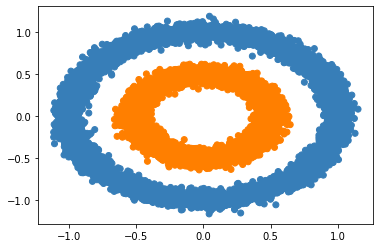

In [20]:
colors = onp.array(list(islice(cycle(
    ['#377eb8', '#ff7f00', '#4daf4a',
     '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00']),
    int(max([1]) + 1))))
X,Y = sklearn.datasets.make_circles(
    n_samples=15000, factor=.5, noise=.05)
plt.scatter(X[:,0],X[:,1],color=colors[Y])

In [3]:
class ShallowNet(flax.nn.Module):
    def apply(self, x, h_dim=5, o_dim=1):
        h = flax.nn.relu(flax.nn.Dense(x, features=h_dim, bias=True))
        y = flax.nn.relu(flax.nn.Dense(h, features=o_dim, bias=False))
        return y
class ShallowClassifier(flax.nn.Module):
    def apply(self, x, h_dim=5, o_dim=1):
        h = flax.nn.tanh(flax.nn.Dense(x, features=h_dim, bias=True))
        y = flax.nn.Dense(h, features=o_dim, bias=False)
        return flax.nn.sigmoid(y)

# Baseline

In [21]:
@jax.vmap
def cross_entropy_loss(p, label):
  return -(label)*jnp.log(p) - (1-label)*(jnp.log(1-p))

@jax.jit
def train_step(optimizer, X_batch, Y_batch):
  def loss_fn(params):
    p_pred = ShallowClassifier.call(params, X_batch, 16, 1)
    loss = jnp.mean(cross_entropy_loss(p_pred, Y_batch))
    return loss
  loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer, loss

prng_key = jax.random.PRNGKey(0)
_, initial_params = ShallowClassifier.init_by_shape(
    prng_key, [ ((2,), jnp.float32) ], 16, 1)
optimizer = flax.optim.Momentum(
    learning_rate=0.1, beta=0.9).create(initial_params)
n_steps = 1000 #2*(X.shape[0]-1)
losses = onp.empty(n_steps)
for i in tqdm.tqdm(range(n_steps)):
    idcs = onp.random.choice(X.shape[0], 32)
    x0, y0 = X[idcs,:], Y[idcs]
    optimizer, loss_val = train_step(optimizer, x0, y0)
    losses[i] = loss_val

100%|██████████| 1000/1000 [00:01<00:00, 563.64it/s]


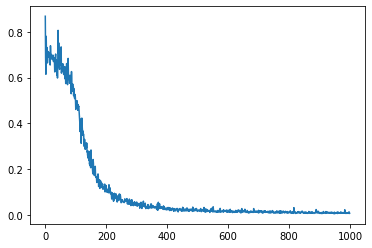

In [22]:
plt.plot(losses)

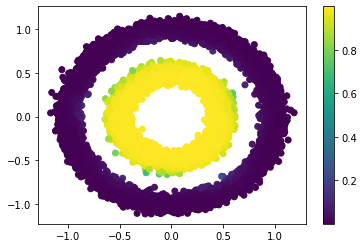

In [23]:
y_pred = ShallowClassifier.call(optimizer.target, X, 16 ,1)
plt.scatter(X[:,1], X[:, 0], c=y_pred)
plt.colorbar()

# Continuous Building Blocks

## Basis functions

In [24]:
def piecewise(param_nodes, t, n_basis):
    idx = min(int(n_basis*t), n_basis-1)
    return param_nodes[idx]


def params_of_t_(param_nodes):
    def theta(t):
        return piecewise(param_nodes, t, len(param_nodes))
    return theta

## Single Step Integrators

In [25]:
# By rigor, one step only evaluates f on the open set [t0, t0+Dt). We substract
# this eps to keep evaluations of params_of_t inside of that interval to align
# with domains.
DT_OPEN_SET_EPS = 1.0e-5

def Euler(params_of_t, x, t0=0, f=None, Dt=1.0):
    return x + Dt * f(params_of_t(t0), x)


def Midpoint(params_of_t, x, t0=0, f=None, Dt=1.0):
    k1 = f(params_of_t(t0), x)
    x1 = x + 0.5*Dt*k1  # t = 1/2
    return x + Dt*f(params_of_t(t+0.5), x1)


def RK4(params_of_t, x, t0=0, f=None, Dt=1.0):
    k1 = f(params_of_t(t0), x)  # t = 0
    x1 = x + 0.5*Dt*k1
    k2 = f(params_of_t(t0+0.5*Dt), x1)  # t = 1/2
    x2 = x + 0.5*Dt*k2
    k3 = f(params_of_t(t0+0.5*Dt), x2)  # t = 1/2
    x3 = x + Dt*k3
    k4 = f(params_of_t(t0+Dt-DT_OPEN_SET_EPS), x3)  # t = 1
    return x + Dt*(1.0/6.0*k1 + 1.0/3.0*k2 + 1.0/3.0*k3 + 1.0/6.0*k4)

## The ContinuousNet

In [26]:
def ContinuousNet(params, x, h_dim, o_dim, n_step=10, scheme=Euler):
    """This function is agnostic to the number of basis functions: it is 
    discovered by n_basis = len(params['ode])."""
    # First, linear transform up to the ode dimenions,
    h = flax.nn.Dense.call(params['front'], x, features=h_dim, bias=False)
    # Create the two functions:
    params_of_t = params_of_t_(params['ode'])  # theta(t)
    f = jax.partial(ShallowNet.call, h_dim=h_dim, o_dim=h_dim)  # f(theta, x)
    # Now loop over depth-time. This happens **statically**
    dt = 1.0/n_step
    for t in onp.linspace(0, 1, n_step):
        # A 'ResNet' is just this...
        # h = h + dt*ShallowNet.call(params_of_t(t), h, h_dim, h_dim)
        # But the general famility is this: (note how params_of_t is a function)
        h = scheme(params_of_t, h, t, f, dt)
    # Now do a linear classifier on the features of h(t=1)
    y = flax.nn.Dense.call(params['back'], h, features=o_dim, bias=False)
    return jax.nn.sigmoid(y)

In [34]:
def copy_and_perturb(params, n_basis):
    """Make copies from a residual trace to make one per coefficient."""
    prng_key = jax.random.PRNGKey(0)
    key, *subkeys = jax.random.split(prng_key, 1+n_basis)
    def _map(x, key):
        return jnp.array(x) + 0.1*jax.random.normal(key, shape=x.shape)
    return [jax.tree_map(lambda x : _map(x, k), params) for k in subkeys ]

def init_ode_by_shape(prng_key, ode_model, n_basis, shape, *args):
    """Make multiple coefficients from params using a flax model."""
    _, params = ode_model.init_by_shape(
        prng_key, shape, *args)
    return copy_and_perturb(params, n_basis)

Initialize the parameter tree. This is awkward right now: I am using a mix of flax's automatic tracing + manual construction to copy multiple values for the basis functions, which flax does not know about.

TODO(afq) Make a basis-function aware flax module.

In [35]:
# Set the training ContNet parameters
h_dim = 3
n_step = 10
scheme = RK4
prng_key = jax.random.PRNGKey(0)
key, *subkeys = jax.random.split(prng_key, 3)
params = {'front': flax.nn.Dense.init_by_shape(prng_key, [(2,)] , features=h_dim, bias=False)[1],
          'ode': init_ode_by_shape(prng_key, ShallowNet, 3, [(h_dim,)], h_dim, h_dim),
          'back':  flax.nn.Dense.init_by_shape(prng_key, [(h_dim,)] , features=1, bias=False)[1],
          }

Now we optimize these parameters for the classification task using binary cross entropy loss.

In [36]:
@jax.vmap
def cross_entropy_loss(p, label):
  "Binary: label is 0 or 1, and p is a scalar probability."
  return -(label)*jnp.log(p) - (1-label)*(jnp.log(1-p))

# Vectorize the OdeNet function for batching.
vContinuousNet = jax.vmap(ContinuousNet, in_axes=(None, 0, None, None, None, None))

@jax.jit
def train_step(optimizer, X_batch, Y_batch):
    """One step of the optimizer, compiled."""
    def loss_fn(params):
        """Take the mean of BCE over the batch."""
        p_pred = vContinuousNet(params, X_batch, h_dim, 1, n_step, scheme)
        loss = jnp.mean(cross_entropy_loss(p_pred, Y_batch))
        return loss
    loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer, loss

optimizer = flax.optim.Momentum(
    learning_rate=0.01, beta=0.9).create(params)
n_steps = 5000 #2*(X.shape[0]-1)
losses = onp.empty(n_steps)
for i in tqdm.tqdm(range(n_steps)):
    idcs = onp.random.choice(X.shape[0], 32)
    x0, y0 = X[idcs,:], Y[idcs]
    optimizer, loss_val = train_step(optimizer, x0, y0)
    losses[i] = loss_val

100%|██████████| 5000/5000 [00:20<00:00, 238.18it/s]


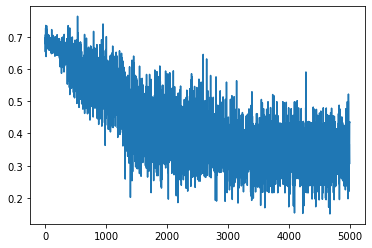

In [37]:
plt.plot(losses)

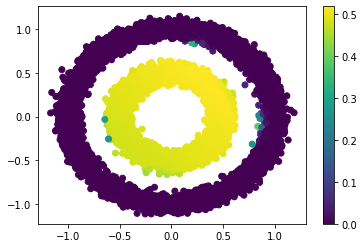

In [38]:
y_pred = ContinuousNet(optimizer.target, X, h_dim, 1, n_step, scheme)
plt.scatter(X[:,1], X[:, 0], c=y_pred)
plt.colorbar()

# Now let's visualize it!

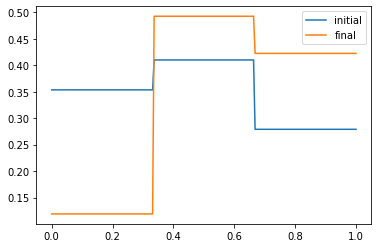

In [39]:
ts = jnp.linspace(0, 1, 200)
params_of_t = params_of_t_(params['ode'])
plt.plot(ts, [params_of_t(t)['Dense_0']['kernel'][1, 1] for t in ts], label='initial')
params_of_t = params_of_t_(optimizer.target['ode'])
plt.plot(ts, [params_of_t(t)['Dense_0']['kernel'][1, 1] for t in ts], label='final')
plt.legend()

In [40]:
from collections import defaultdict
import re
import graphviz

In [41]:
STYLES = {
    'invar': {'shape':'oval', 'style':'filled', 'color':'green'},
    'primitive': {'shape':'rect', 'style':'filled', 'color':'lightblue'},
    'outvar': {'shape':'oval', 'style':'filled', 'color':'red'},
    'constant': {'shape':'oval', 'style':'filled', 'color':'yellow'}
}

EDGE_STYLES = {
    'param': {'weight':' 1.0', 'style':'dashed'},
    'primitive': {'weight': '10.0'}
}

is_var = re.compile("[a-z]+")

def make_graph(jxpr) -> graphviz.Digraph:
    dot = graphviz.Digraph(engine='dot', graph_attr={'overlap_shrink':'true'})

    # Track and make nodes for input and output variables
    real_vars = set([str(v) for v in jxpr.jaxpr.invars + jxpr.jaxpr.outvars])
    for invar in jxpr.jaxpr.invars:
        dot.node(str(invar), str(invar), STYLES['invar'] )
    for outvar in jxpr.jaxpr.outvars:
        dot.node(str(outvar), str(outvar), STYLES['outvar'])

    # Collapse the internal "temp" variables to become labels on op->op edges.
    edge_vars = defaultdict(lambda : [])
    for i, eq in enumerate(jxpr.jaxpr.eqns):
        pname = f"{str(eq.primitive)}{i}"
        for outvar in eq.outvars:
            edge_vars[str(outvar)] = []
        for invar in eq.invars:
            edge_vars[str(invar)].append(pname)

    # Trace all of the equations (i.e., NN ops) to connect the graph
    for i, eq in enumerate(jxpr.jaxpr.eqns):
        node_name = f"{str(eq.primitive)}{i}"
        dot.node(node_name, str(eq.primitive), STYLES['primitive'])
        for invar in eq.invars:
            if not is_var.match(str(invar)):
                dot.node(f"const_{i}", f"{float(str(invar)):0.2}", STYLES['constant'])
                dot.edge(f"const_{i}", node_name, **EDGE_STYLES['param'])
            if str(invar) in real_vars:
                dot.edge(str(invar), node_name, **EDGE_STYLES['param'])
        for outvar in eq.outvars:
            if str(outvar) in real_vars:
                dot.edge(node_name, str(outvar), **EDGE_STYLES['param'])
            else:
                for out_primitive in edge_vars[str(outvar)]:
                    dot.edge(node_name, out_primitive, str(outvar), **EDGE_STYLES['primitive'])

    # for i, eq in enumerate(jxpr.jaxpr.eqns):
    #     for invar in eq.invars:
    #         if is_var.match(str(invar)):
    #             dot.node(str(invar))
    #             dot.edge(str(invar), pname)
    #     dot.node(pname, pname, STYLES['primitive'])
    #     for outvar in eq.outvars:
    #         dot.node(str(outvar))
    #         dot.edge(pname, str(outvar))
    return dot

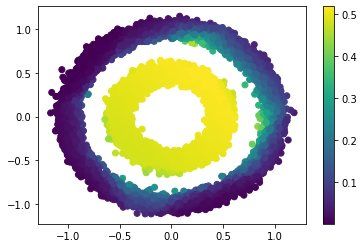

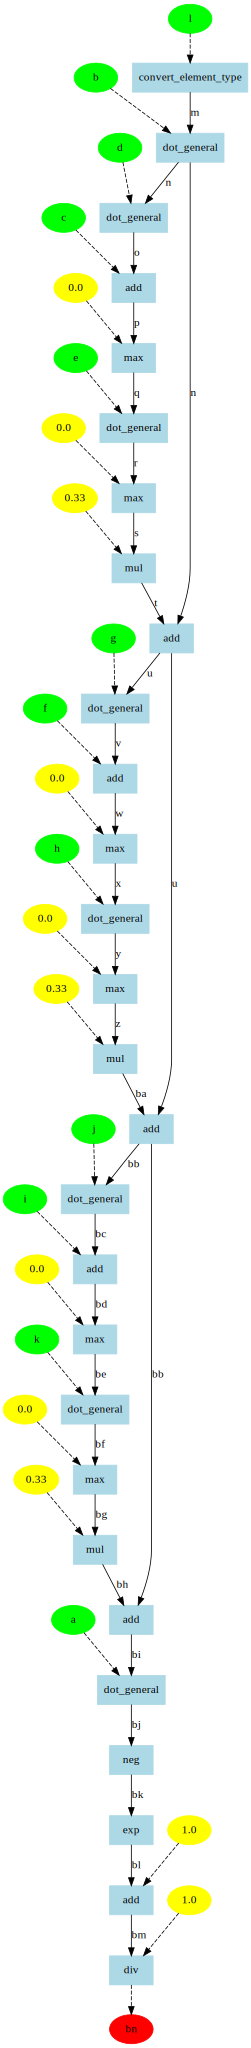

In [43]:
onet = jax.partial(ContinuousNet, h_dim=h_dim, o_dim=1, n_step=3, scheme=Euler)
y_pred = onet(optimizer.target, X)
plt.scatter(X[:,1], X[:, 0], c=y_pred)
plt.colorbar()
plt.show()
jxpr = jax.make_jaxpr(onet)(params, jnp.array([1,1]))
make_graph(jxpr)

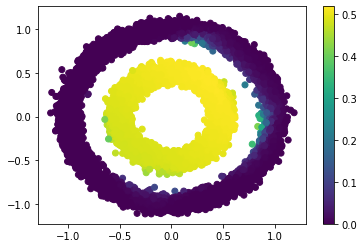

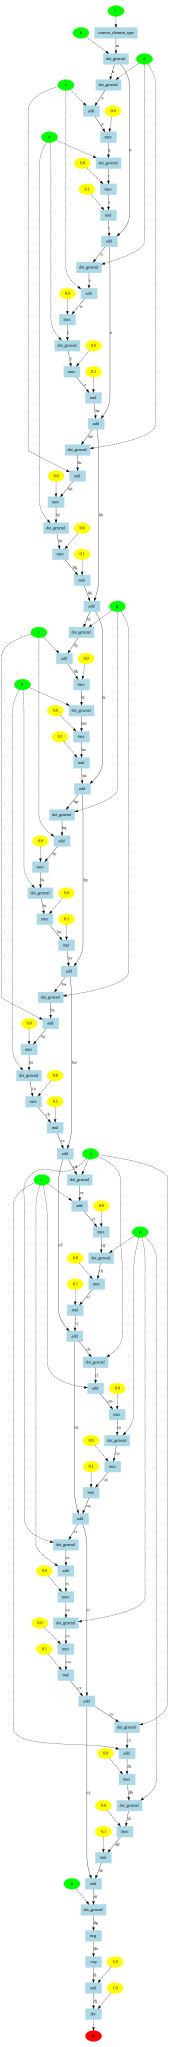

In [45]:
onet = jax.partial(ContinuousNet, h_dim=h_dim, o_dim=1, n_step=10, scheme=Euler)
y_pred = onet(optimizer.target, X)
plt.scatter(X[:,1], X[:, 0], c=y_pred)
plt.colorbar()
plt.show()
jxpr = jax.make_jaxpr(onet)(params, jnp.array([1,1]))
make_graph(jxpr)

In [ ]:
dot.render(root+"/graph")

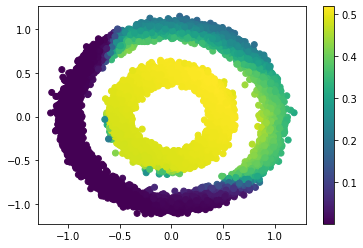

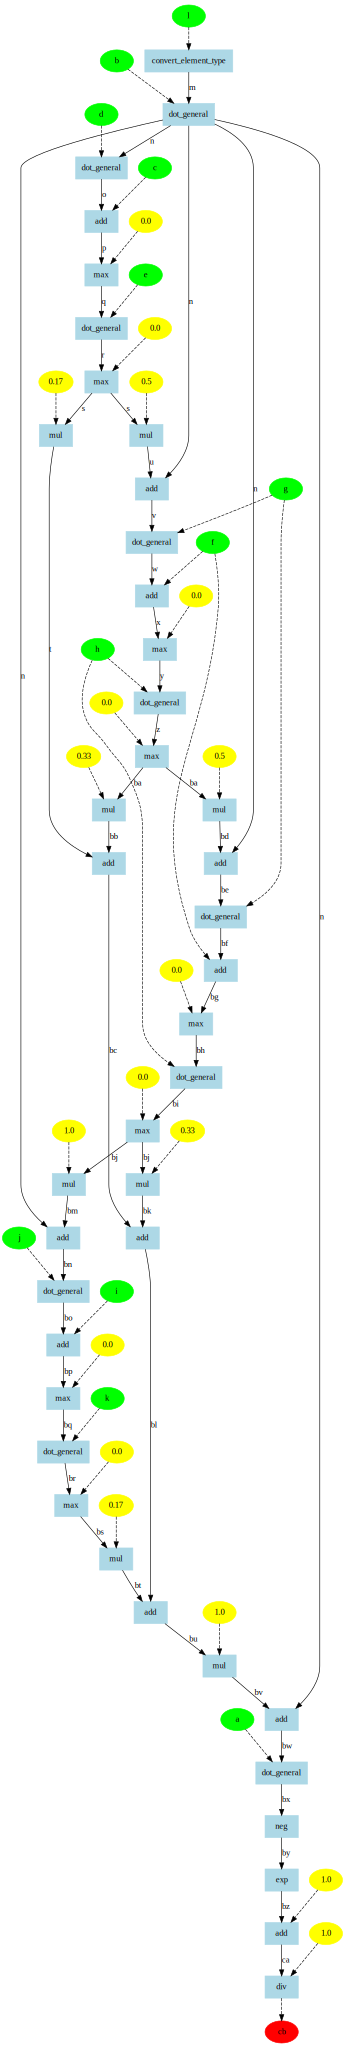

In [44]:
onet = jax.partial(ContinuousNet, h_dim=h_dim, o_dim=1, n_step=1, scheme=RK4)
y_pred = onet(optimizer.target, X)
plt.scatter(X[:,1], X[:, 0], c=y_pred)
plt.colorbar()
plt.show()
jxpr = jax.make_jaxpr(onet)(params, jnp.array([1,1]))
make_graph(jxpr)

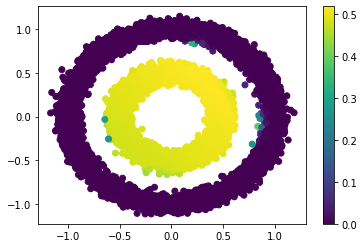

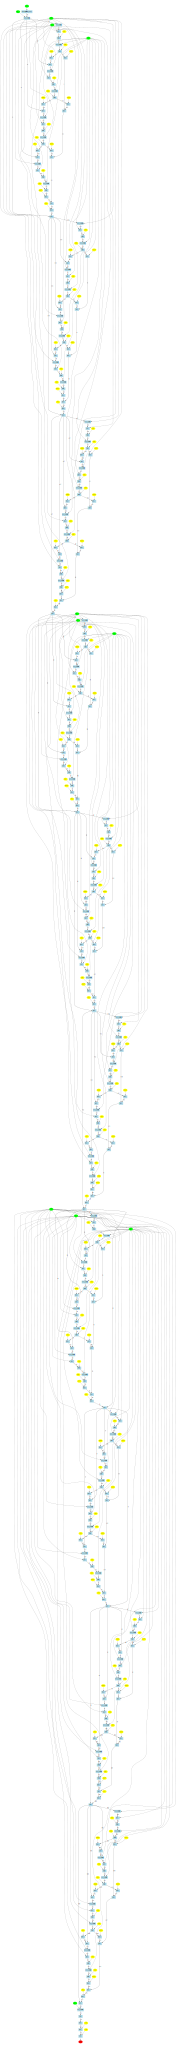

In [46]:
onet = jax.partial(ContinuousNet, h_dim=h_dim, o_dim=1, n_step=10, scheme=RK4)
y_pred = onet(optimizer.target, X)
plt.scatter(X[:,1], X[:, 0], c=y_pred)
plt.colorbar()
plt.show()
jxpr = jax.make_jaxpr(onet)(params, jnp.array([1,1]))
make_graph(jxpr)